In [8]:
# ================================
# Spark monthly pipeline for NSW permanent traffic counts
# - Reads 4 hourly CSVs + station_ref from HDFS
# - Cleans & aggregates to monthly
# - Joins metadata
# - Writes curated dataset
# - Demonstrates CRUD by overwrite
# - 4 rubric-aligned Spark SQL queries
# ================================

from pyspark.sql import SparkSession, functions as F, types as T

spark = (
    SparkSession.builder
    .appName("nsw_traffic_monthly_pipeline")
    .config("spark.sql.session.timeZone", "UTC")
    .getOrCreate()
)

# ----------------
# 0) HDFS paths
# ----------------
hourly_paths = [
    "hdfs://namenode:8020/data/raw/road_traffic_counts_hourly_permanent0.csv",
    "hdfs://namenode:8020/data/raw/road_traffic_counts_hourly_permanent1.csv",
    "hdfs://namenode:8020/data/raw/road_traffic_counts_hourly_permanent2.csv",
    "hdfs://namenode:8020/data/raw/road_traffic_counts_hourly_permanent3.csv",
]
ref_path = "hdfs://namenode:8020/data/raw/station_ref.csv"
curated_path = "hdfs://namenode:8020/data/curated/traffic_monthly"


In [13]:

ref_sel = (
    spark.read.option("header", True).option("inferSchema", True)
        .csv("hdfs://namenode:8020/data/raw/station_ref.csv")
        .select(
            F.col("station_id").cast("string"),
            F.col("rms_region"),
            F.col("lga"),
            F.col("suburb"),
            F.col("road_functional_hierarchy"),
            F.col("road_classification_type"),
            F.col("lane_count").cast("int"),
            F.col("wgs84_latitude").cast("double").alias("latitude"),
            F.col("wgs84_longitude").cast("double").alias("longitude"),
            F.col("road_name"),
            F.col("permanent_station"),
            F.col("device_type")
        )
        .dropna(subset=["station_id"])
        .dropDuplicates(["station_id"])
        .withColumn("lane_count", F.when((F.col("lane_count").isNull()) | (F.col("lane_count") <= 0), 1)
                                   .otherwise(F.col("lane_count")))
)

ref_sel.printSchema()
print(f"Stations kept: {ref_sel.count()}")

root
 |-- station_id: string (nullable = true)
 |-- rms_region: string (nullable = true)
 |-- lga: string (nullable = true)
 |-- suburb: string (nullable = true)
 |-- road_functional_hierarchy: string (nullable = true)
 |-- road_classification_type: string (nullable = true)
 |-- lane_count: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- road_name: string (nullable = true)
 |-- permanent_station: integer (nullable = true)
 |-- device_type: string (nullable = true)

Stations kept: 1783


In [14]:
# 1) Load & union
hourly = spark.read.option("header", True).option("inferSchema", True).csv(hourly_paths)
print("Columns:", hourly.columns)
hourly.printSchema()

# 2) Core exploration metrics
raw_rows = hourly.count()
distinct_stations = hourly.select(F.col("station_key").cast("string")).distinct().count()

date_min = hourly.select(F.min(F.to_timestamp("date")).alias("min")).collect()[0]["min"]
date_max = hourly.select(F.max(F.to_timestamp("date")).alias("max")).collect()[0]["max"]

print(f"RAW rows: {raw_rows}")
print(f"Distinct stations: {distinct_stations}")
print(f"Date range: {date_min} → {date_max}")

# 3) Null rates for critical columns (station_key, date, daily_total)
def null_rate(col):
    return (F.sum(F.when(F.col(col).isNull(), 1).otherwise(0)) / F.count(F.lit(1))).alias(f"null_rate_{col}")

nulls = hourly.select(
    null_rate("station_key"),
    null_rate("date"),
    null_rate("daily_total")
).toPandas()
print(nulls)

# 4) Peek a few rows (for the report)
hourly.select("station_key","date","year","month","day_of_week","daily_total","hour_00","hour_07","hour_17","hour_23") \
      .show(10, truncate=False)

# 5) Prepare a candidate daily total (for Block 2)
hour_cols = [c for c in hourly.columns if c.lower().startswith("hour_")]
daily_total_candidate = F.coalesce(
    F.col("daily_total").cast("double"),
    sum([F.coalesce(F.col(c).cast("double"), F.lit(0.0)) for c in hour_cols])
)

print(f"Hour columns detected: {len(hour_cols)} -> {hour_cols[:6]}{' ...' if len(hour_cols) > 6 else ''}")

Columns: ['the_geom', 'cartodb_id', 'the_geom_webmercator', 'record_id', 'station_key', 'traffic_direction_seq', 'cardinal_direction_seq', 'classification_seq', 'date', 'year', 'month', 'day_of_week', 'public_holiday', 'school_holiday', 'daily_total', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'md5', 'updated_on']
root
 |-- the_geom: string (nullable = true)
 |-- cartodb_id: integer (nullable = true)
 |-- the_geom_webmercator: string (nullable = true)
 |-- record_id: integer (nullable = true)
 |-- station_key: integer (nullable = true)
 |-- traffic_direction_seq: integer (nullable = true)
 |-- cardinal_direction_seq: integer (nullable = true)
 |-- classification_seq: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 

In [53]:
from pyspark.sql import functions as F

summary_rows = (spark.createDataFrame([
    ("raw_hourly", raw_rows, len(hourly.columns), str(hourly.schema.simpleString())),
    ("monthly_clean", monthly_clean.count(), len(monthly_clean.columns), str(monthly_clean.schema.simpleString())),
    ("curated_enriched", cur_u.count(), len(cur_u.columns), str(cur_u.schema.simpleString())),
], ["dataset","rows","n_columns","schema"]))
summary_rows.show(truncate=False)

# One-liners to print headline facts for the report:
print(f"Raw hourly rows: {raw_rows:,}")
print(f"Stations (distinct): {distinct_stations:,}")
date_min = hourly.select(F.min(F.to_timestamp("date")).alias("min")).collect()[0]["min"]
date_max = hourly.select(F.max(F.to_timestamp("date")).alias("max")).collect()[0]["max"]
print(f"Date range: {date_min.date()} to {date_max.date()}")
print(f"Curated monthly rows: {cur_u.count():,}")


+----------------+-------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|dataset         |rows   |n_columns|schema                                                                                                                                                                                                                                                                                                   

In [15]:
# ===== Block 2: Cleaning + Monthly Aggregation =====
from pyspark.sql import functions as F

# Build a clean daily_total column: use existing if valid, else sum of hour_00..hour_23
hour_cols = [c for c in hourly.columns if c.lower().startswith("hour_")]
hourly = hourly.withColumn(
    "daily_total_clean",
    F.coalesce(
        F.col("daily_total").cast("double"),
        sum([F.coalesce(F.col(c).cast("double"), F.lit(0.0)) for c in hour_cols])
    )
)

# Convert to proper timestamp and keep useful columns
hourly_clean = (
    hourly
    .withColumn("station_key", F.col("station_key").cast("string"))
    .withColumn("date_ts", F.to_timestamp("date"))
    .select("station_key","year","month","date_ts","daily_total_clean")
    .dropna(subset=["station_key","date_ts"])   # remove missing keys or dates
    .filter(F.col("daily_total_clean").isNotNull() & (F.col("daily_total_clean") >= 0))
    .withColumn("year_month", F.date_format("date_ts","yyyy-MM"))
)

# --- simple quality summary ---
raw_rows = hourly.count()
clean_rows = hourly_clean.count()
stations = hourly_clean.select("station_key").distinct().count()

print(f"Raw rows: {raw_rows}")
print(f"After cleaning: {clean_rows}")
print(f"Distinct stations: {stations}")
print(f"Data coverage: {hourly_clean.select(F.min('date_ts'),F.max('date_ts')).collect()}")

# --- monthly aggregation ---
monthly_clean = (
    hourly_clean
    .groupBy("station_key","year_month")
    .agg(
        F.sum("daily_total_clean").alias("sum_daily_total_month"),
        F.avg("daily_total_clean").alias("avg_daily_in_month"),
        F.count(F.lit(1)).alias("n_days")
    )
    .orderBy("station_key","year_month")
)

monthly_clean.createOrReplaceTempView("traffic_monthly")
monthly_clean.show(10, truncate=False)

# quick record of aggregation completeness
print(f"Monthly records: {monthly_clean.count()}")

Raw rows: 3925503
After cleaning: 3925503
Distinct stations: 711
Data coverage: [Row(min(date_ts)=datetime.datetime(2006, 1, 1, 0, 0), max(date_ts)=datetime.datetime(2025, 9, 1, 0, 0))]
+-----------+----------+---------------------+------------------+------+
|station_key|year_month|sum_daily_total_month|avg_daily_in_month|n_days|
+-----------+----------+---------------------+------------------+------+
|-1         |2019-01   |5034.0               |139.83333333333334|36    |
|-1         |2019-02   |4809.0               |141.44117647058823|34    |
|-1         |2019-03   |4400.0               |146.66666666666666|30    |
|113526     |2025-02   |973777.0             |22131.295454545456|44    |
|113526     |2025-03   |2727289.0            |21994.266129032258|124   |
|113526     |2025-04   |2613138.0            |21776.15          |120   |
|113526     |2025-05   |1546842.0            |19335.525         |80    |
|113526     |2025-06   |2588267.0            |21568.891666666666|120   |
|113526    

In [22]:
# === Block 3: Enrich monthly with reference (per station_key × year_month) ===
from pyspark.sql import functions as F

# 3.1 Load a slim reference with only the columns we want for analysis
ref_slim = (
    spark.read.option("header", True).option("inferSchema", True)
      .csv("hdfs://namenode:8020/data/raw/station_ref.csv")
      .select(
          F.col("station_key").cast("string"),
          F.col("station_id").cast("string"),
          F.col("rms_region"),
          F.col("lga"),
          F.col("suburb"),
          F.col("road_functional_hierarchy"),
          F.col("road_classification_type"),
          F.col("lane_count").cast("int"),
          F.col("device_type"),
          F.col("wgs84_latitude").cast("double").alias("latitude"),
          F.col("wgs84_longitude").cast("double").alias("longitude"),
          F.col("road_name")
      )
      .dropna(subset=["station_key"])
      .dropDuplicates(["station_key"])  # ensure 1 row per station_key to avoid duplication
      .withColumn("lane_count", F.when((F.col("lane_count").isNull()) | (F.col("lane_count") <= 0), 1)
                                 .otherwise(F.col("lane_count")))
)

# 3.2 Keep your monthly grain (station_key × year_month), enrich with attributes
curated = (
    monthly_clean.alias("m")
    .join(ref_slim.alias("r"), on="station_key", how="left")  # many rows per station across months remain
    .select(
        "m.station_key",
        "m.year_month",
        "m.sum_daily_total_month",
        "m.avg_daily_in_month",
        "m.n_days",
        "r.station_id",
        "r.rms_region","r.lga","r.suburb",
        "r.road_functional_hierarchy","r.road_classification_type",
        "r.lane_count","r.device_type",
        "r.latitude","r.longitude","r.road_name"
    )
    .withColumn("volume_per_lane", F.col("sum_daily_total_month") / F.col("lane_count"))
)

# === Safe HDFS persistence for academic submission (CSV instead of Parquet) ===
curated_path_csv = "hdfs://namenode:8020/data/curated/traffic_monthly_csv"

(curated
 .coalesce(1)
 .write.mode("overwrite")
 .option("header", True)
 .csv(curated_path_csv))

print("Curated monthly (enriched) saved as CSV to HDFS")

Curated monthly (enriched) saved as CSV to HDFS


In [26]:
# === Block 4: CRUD simulation directly on curated DataFrame ===
from pyspark.sql import functions as F

# We'll operate directly on the in-memory DataFrame 'curated'
cur = curated

# UPDATE example:
# - Normalise region labels (UPPER/TRIM)
# - Recompute volume_per_lane if lane_count changed
cur_u = (
    cur.withColumn("rms_region", F.upper(F.trim(F.col("rms_region"))))
       .withColumn("lane_count",
                   F.when((F.col("lane_count").isNull()) | (F.col("lane_count") <= 0), F.lit(1))
                    .otherwise(F.col("lane_count")))
       .withColumn("volume_per_lane", F.col("sum_daily_total_month") / F.col("lane_count"))
)

# Register the updated DataFrame as the active SQL view
cur_u.createOrReplaceTempView("traffic_monthly_curated")

print("CRUD complete (UPDATE applied in-memory, view refreshed)")


CRUD complete (UPDATE applied in-memory, view refreshed)


In [40]:
# === Block 5: Execute and display results of all four analyses ===

# Q1. Top 3 regions with the highest traffic growth (exclude NULL)
q1 = spark.sql("""
SELECT
  rms_region,
  MIN(year_month) AS first_month,
  MAX(year_month) AS last_month,
  ROUND((MAX(sum_daily_total_month) - MIN(sum_daily_total_month)) / MIN(sum_daily_total_month) * 100, 2)
    AS growth_percent
FROM traffic_monthly_curated
WHERE rms_region IS NOT NULL AND rms_region != ''
GROUP BY rms_region
ORDER BY growth_percent DESC
LIMIT 3
""")
print("\n=== Q1. Top 3 Regions with Highest Traffic Growth (excluding NULL) ===")
q1.show(truncate=False)


=== Q1. Top 3 Regions with Highest Traffic Growth (excluding NULL) ===
+----------+-----------+----------+--------------+
|rms_region|first_month|last_month|growth_percent|
+----------+-----------+----------+--------------+
|SOUTH WEST|2009-08    |2025-08   |5.02291E7     |
|WESTERN   |2008-10    |2025-08   |3.85399E7     |
|NORTHERN  |2008-08    |2025-08   |554835.13     |
+----------+-----------+----------+--------------+



Saved fig_q1_growth.png


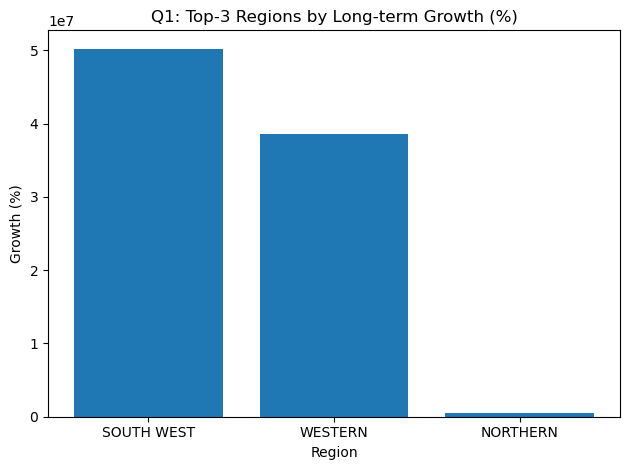

In [49]:
import matplotlib.pyplot as plt

pdf_q1 = q1.toPandas()
plt.figure()
plt.bar(pdf_q1["rms_region"], pdf_q1["growth_percent"])
plt.title("Q1: Top-3 Regions by Long-term Growth (%)")
plt.xlabel("Region")
plt.ylabel("Growth (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("fig_q1_growth.png", dpi=160)
print("Saved fig_q1_growth.png")


In [46]:
# Q2 Urban Pressure Score — composite indicator (last 3 years only)
q2 = spark.sql("""
SELECT
  rms_region,
  ROUND(SUM(sum_daily_total_month) / COUNT(DISTINCT station_key), 2) AS load_per_station,
  ROUND(AVG(volume_per_lane), 2) AS avg_efficiency,
  ROUND(
      (SUM(sum_daily_total_month) / COUNT(DISTINCT station_key)) * AVG(volume_per_lane) / 1000000,
      2
  ) AS pressure_score
FROM traffic_monthly_curated
WHERE rms_region IS NOT NULL
  AND rms_region != ''
  AND rms_region != 'NULL'
  AND CAST(SUBSTRING(year_month, 1, 4) AS INT) >= 2023
GROUP BY rms_region
ORDER BY pressure_score DESC
LIMIT 5
""")

print("\n=== Q2 Urban Pressure Score (2023–2025 only) ===")
q2.show(truncate=False)


=== Q2 Urban Pressure Score (2023–2025 only) ===
+----------+----------------+--------------+--------------+
|rms_region|load_per_station|avg_efficiency|pressure_score|
+----------+----------------+--------------+--------------+
|SYDNEY    |1.273170673E7   |625438.9      |7962904.66    |
|HUNTER    |8556348.05      |411362.89     |3519764.04    |
|SOUTHERN  |4988093.75      |214926.84     |1072075.23    |
|SOUTH WEST|3876252.5       |209527.16     |812180.19     |
|WESTERN   |3089160.42      |139747.73     |431703.17     |
+----------+----------------+--------------+--------------+



Saved fig_q3_seasonality.png


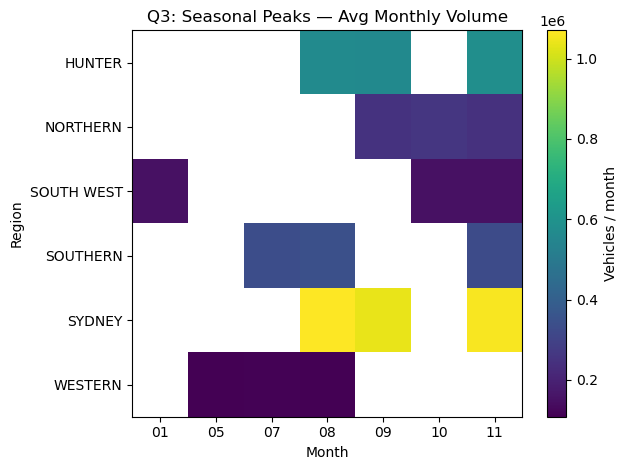

In [50]:
import numpy as np

pdf_q3 = q3.toPandas()
pivot = pdf_q3.pivot(index="rms_region", columns="month_of_year", values="avg_monthly_volume")
pivot = pivot.sort_index().reindex(sorted(pivot.columns, key=lambda m: int(m)), axis=1)

plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.title("Q3: Seasonal Peaks — Avg Monthly Volume")
plt.xlabel("Month")
plt.ylabel("Region")
plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns)
plt.yticks(ticks=np.arange(pivot.shape[0]), labels=pivot.index)
plt.colorbar(label="Vehicles / month")
plt.tight_layout()
plt.savefig("fig_q3_seasonality.png", dpi=160)
print("Saved fig_q3_seasonality.png")


In [44]:
# Q3. Top 3 months with highest average volume per region (seasonality)
q3 = spark.sql("""
SELECT rms_region, month_of_year, avg_monthly_volume FROM (
  SELECT
    rms_region,
    SUBSTRING(year_month, 6, 2) AS month_of_year,
    ROUND(AVG(sum_daily_total_month), 2) AS avg_monthly_volume,
    RANK() OVER (PARTITION BY rms_region ORDER BY AVG(sum_daily_total_month) DESC) AS rk
  FROM traffic_monthly_curated
  WHERE rms_region IS NOT NULL AND rms_region != '' AND rms_region != 'NULL'
  GROUP BY rms_region, SUBSTRING(year_month, 6, 2)
)
WHERE rk <= 3 AND rms_region IS NOT NULL AND rms_region != ''
ORDER BY rms_region, avg_monthly_volume DESC
""")
print("\n=== Q3. Seasonal Peaks (Top 3 Months per Region) ===")
q3.show(20, False)


=== Q3. Seasonal Peaks (Top 3 Months per Region) ===
+----------+-------------+------------------+
|rms_region|month_of_year|avg_monthly_volume|
+----------+-------------+------------------+
|HUNTER    |11           |583478.88         |
|HUNTER    |08           |567257.06         |
|HUNTER    |09           |563244.68         |
|NORTHERN  |10           |258816.32         |
|NORTHERN  |09           |249260.38         |
|NORTHERN  |11           |247074.55         |
|SOUTH WEST|10           |153131.19         |
|SOUTH WEST|01           |152736.22         |
|SOUTH WEST|11           |150361.35         |
|SOUTHERN  |08           |344548.15         |
|SOUTHERN  |07           |337031.3          |
|SOUTHERN  |11           |327064.09         |
|SYDNEY    |08           |1070233.69        |
|SYDNEY    |11           |1059918.23        |
|SYDNEY    |09           |1039634.29        |
|WESTERN   |07           |112340.44         |
|WESTERN   |05           |111767.15         |
|WESTERN   |08           |

Saved fig_q3_seasonality.png


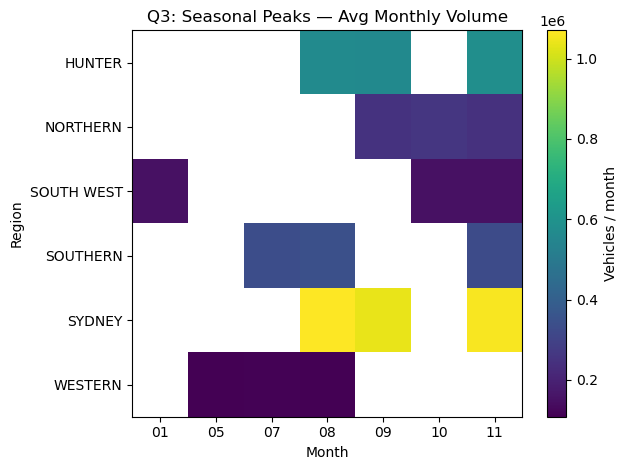

In [51]:
import numpy as np

pdf_q3 = q3.toPandas()
pivot = pdf_q3.pivot(index="rms_region", columns="month_of_year", values="avg_monthly_volume")
pivot = pivot.sort_index().reindex(sorted(pivot.columns, key=lambda m: int(m)), axis=1)

plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.title("Q3: Seasonal Peaks — Avg Monthly Volume")
plt.xlabel("Month")
plt.ylabel("Region")
plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns)
plt.yticks(ticks=np.arange(pivot.shape[0]), labels=pivot.index)
plt.colorbar(label="Vehicles / month")
plt.tight_layout()
plt.savefig("fig_q3_seasonality.png", dpi=160)
print("Saved fig_q3_seasonality.png")


In [43]:
# Q4. Capacity-normalised analysis — find regions with most efficient lanes (exclude NULL)
q4 = spark.sql("""
SELECT
  rms_region,
  ROUND(AVG(volume_per_lane), 2) AS avg_volume_per_lane,
  ROUND(MAX(volume_per_lane), 2) AS peak_volume_per_lane,
  COUNT(DISTINCT station_key) AS n_stations
FROM traffic_monthly_curated
WHERE rms_region IS NOT NULL AND rms_region != '' AND rms_region != 'NULL'
GROUP BY rms_region
ORDER BY avg_volume_per_lane DESC
LIMIT 5
""")

print("\n=== Q4. Top 5 Regions by Lane Efficiency===")
q4.show(truncate=False)



=== Q4. Top 5 Regions by Lane Efficiency===
+----------+-------------------+--------------------+----------+
|rms_region|avg_volume_per_lane|peak_volume_per_lane|n_stations|
+----------+-------------------+--------------------+----------+
|SYDNEY    |993057.24          |4938927.0           |295       |
|HUNTER    |528337.15          |2587643.0           |73        |
|SOUTHERN  |315900.18          |2499272.0           |80        |
|NORTHERN  |233078.55          |2164247.0           |30        |
|SOUTH WEST|140517.83          |502292.0            |17        |
+----------+-------------------+--------------------+----------+



Saved fig_q4_lane_efficiency.png


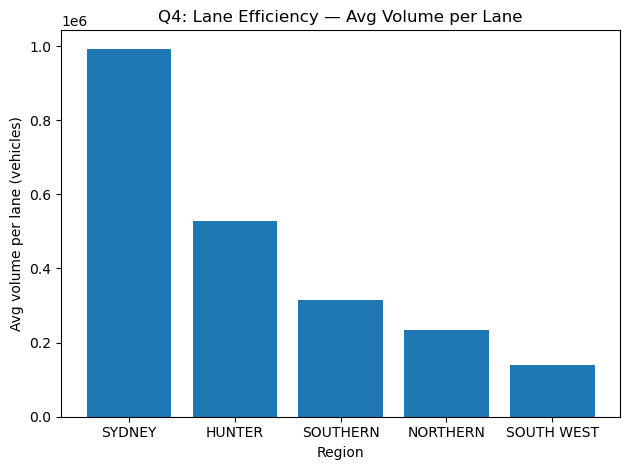

In [52]:
pdf_q4 = q4.toPandas()
plt.figure()
plt.bar(pdf_q4["rms_region"], pdf_q4["avg_volume_per_lane"])
plt.title("Q4: Lane Efficiency — Avg Volume per Lane")
plt.xlabel("Region")
plt.ylabel("Avg volume per lane (vehicles)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("fig_q4_lane_efficiency.png", dpi=160)
print("Saved fig_q4_lane_efficiency.png")
